In [1]:
import pathlib
import pandas as pd
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))
from transects import Transects
from reports import Reports
import pathlib

In [ ]:
test_run = "label data inference 2048 all"
confidence_threshold = 0.5  # Set the confidence threshold for filtering detections
PATHS = {
    "annual_inference_assmt" : r"Z:\__AdvancedTechnologyBackup\03_InferenceResults\GobyFinder\inference_assessment_all_clean.pkl",
    "weights": r"Z:\__AdvancedTechnologyBackup\06_ModelWeights\GobyFinderAUV2048.pt",
    "poly_lbl_assmt": r"Z:\__AdvancedTechnologyBackup\07_Database\FishScaleLabelAssessment\2020-2023_assessment_confirmedfish.pkl",
    "op_table": r"Z:\__AdvancedTechnologyBackup\07_Database\OP_TABLE.xlsx",
    "metadata": r"Z:\__AdvancedTechnologyBackup\07_Database\MetadataCombined\all_annotated_meta_splits_20250915.csv",
    "img_directory": r"Z:\__Organized_Directories_InProgress\GobyFinderDatasets\AUV_datasets\images",
    "run_folder": f"C:\\Users\\ageglio\\ageglio-1\\gobyfinder_yolov8\\output\\test_runs\\{test_run}", 
}
PATHS.update({
    "new_inference_assmt": os.path.join(PATHS["run_folder"], "inference_results.csv"),
    "fndf": os.path.join(PATHS["run_folder"], "false_negatives.csv"),
    "lbl_box_results": os.path.join(PATHS["run_folder"], "label_box_results.csv"),
    "scores_df": os.path.join(PATHS["run_folder"], "scores.csv"),
    "lbl_df": os.path.join(PATHS["run_folder"], "labels.csv"),
    "pred_df": os.path.join(PATHS["run_folder"], "predictions.csv"),
})    
paths = {key: pathlib.Path(value) for key, value in PATHS.items()}
# Define the sets of collect_ids for each split
COLLECT_IDS = {
    "transects": {"20200806_001_Iver3069_ABS1", "20200816_001_Iver3069_ABS1",
                  "20210825_001_Iver3069_ABS1", "20210720_001_Iver3069_ABS1"},
    "test": {"20200809_001_Iver3069_ABS1", "20200818_001_Iver3069_ABS1", "20200902_001_Iver3069_ABS1", "20200820_001_Iver3069_ABS1", "20200821_001_Iver3069_ABS1", "20200823_001_Iver3069_ABS1",
             "20210811_001_Iver3069_ABS1", "20210812_001_Iver3069_ABS1", "20210812_002_Iver3069_ABS1", "20210719_001_Iver3069_ABS1", "20210829_001_Iver3069_ABS1", "20210911_001_Iver3069_ABS1", "20210911_002_Iver3069_ABS1", "20210925_001_Iver3069_ABS1",
             "20220624_001_Iver3069_ABS1", "20220714_002_Iver3069_ABS1", "20220727_001_Iver3069_ABS2", "20220811_002_Iver3098_ABS2", "20220807_003_Iver3069_ABS2", "20220901_001_Iver3069_ABS2", "20220814_001_Iver3069_ABS2", "20220814_002_Iver3069_ABS2",
             "20230710_001_Iver3098_ABS2", "20230909_001_Iver3069_ABS2", "20230810_002_Iver3098_ABS2", "20230727_001_Iver3098_ABS2"},
    "validation": {"20200916_001_Iver3069_ABS1", "20200922_002_Iver3069_ABS1", "20200923_002_Iver3069_ABS1",
                   "20210712_001_Iver3069_ABS1", "20210909_001_Iver3069_ABS1", "20210920_001_Iver3069_ABS1", "20210707_001_Iver3069_ABS1", "20210912_001_Iver3069_ABS1", "20210912_002_Iver3069_ABS1", "20210913_001_Iver3069_ABS1",
                   "20220711_002_Iver3069_ABS1", "20220714_003_Iver3069_ABS1", "20220717_001_Iver3098_ABS2", "20220825_001_Iver3098_ABS2", "20220914_002_Iver3069_ABS2", "20220902_001_Iver3069_ABS2",
                   "20230802_001_Iver3098_ABS2", "20230625_001_Iver3098_ABS2", "20230718_002_Iver3098_ABS2", "20230811_001_Iver3098_ABS2", "20230715_001_Iver3098_ABS2"}
}

In [3]:
confidence_threshold = 0.25
# Print the terminal command to run the inference results script
# Construct the command using an f-string and .as_posix()
command = (
    f"python scripts/runResults.py "
    f"--img_directory '{paths['img_directory'].as_posix()}' "
    f"--weights '{paths['weights'].as_posix()}' "
    f"--op_table '{paths['op_table'].as_posix()}' "
    f"--metadata '{paths['metadata'].as_posix()}' "
    f"--output_name 'label data inference 2048 all' "
    f"--has_labels "
    f"--results_confidence {confidence_threshold}"
)

print(command)

python scripts/runResults.py --img_directory 'Z:/__Organized_Directories_InProgress/GobyFinderDatasets/AUV_datasets/images' --weights 'Z:/__AdvancedTechnologyBackup/06_ModelWeights/GobyFinderAUV2048.pt' --op_table 'Z:/__AdvancedTechnologyBackup/07_Database/OP_TABLE.xlsx' --metadata 'Z:/__AdvancedTechnologyBackup/07_Database/MetadataCombined/all_annotated_meta_splits_20250915.csv' --output_name 'label data inference 2048 all' --has_labels --results_confidence 0.25


In [4]:
# import assessment and label results
collect_id = '20200806_001_Iver3069_ABS1'
# Usable image list based on metadata
usable_images = pd.read_csv(PATHS["metadata"], usecols=["Filename", "Usability", "collect_id"])
usable_images = usable_images[usable_images.collect_id == collect_id]
usable_images = usable_images[usable_images.Usability=="Usable"].Filename.tolist()

# Load inference assessment and label box results
# This is the inference results from the runResults.py script
inference_assmt = pd.read_csv(PATHS["new_inference_assmt"])
inference_assmt = inference_assmt[inference_assmt.Filename.isin(usable_images)]
print("inference results confidence threshold", f"{inference_assmt[inference_assmt.conf_pass==1].conf.min():0.2f}")
# Load the label box results also from the runResults.py script
lblres = pd.read_csv(PATHS["lbl_box_results"], index_col=0)
lblres = lblres[lblres.Filename.isin(usable_images)]

# Load the FishScale polynomial assessment where full segmentation was required
poly_lbl_assmt = pd.read_pickle(PATHS["poly_lbl_assmt"])
poly_lbl_assmt = poly_lbl_assmt[poly_lbl_assmt.Filename.isin(usable_images)]

# filter inference and label results for transects
infer_transects = inference_assmt
lblres_transects = lblres
poly_assmt_transects = poly_lbl_assmt
scores_df = pd.read_csv(PATHS["scores_df"], index_col=0)
scores_df = scores_df[scores_df.Filename.isin(infer_transects.Filename.to_list())]
tpd = scores_df[scores_df.tp==1].detect_id
fpd = scores_df[scores_df.fp==1].detect_id
fndf = pd.read_csv(PATHS["fndf"])
fnid = fndf.ground_truth_id

inference results confidence threshold 0.30


In [9]:
# --- Total Weights (g) ---
filt_wt = 80
total_lbl_box_weight = lblres_transects[lblres_transects.box_DL_weight_g_corr<=filt_wt].box_DL_weight_g_corr.sum()  # Filter out weights > 80g
total_poly_weight = poly_assmt_transects[poly_assmt_transects.Poly_Corr_weight_g<=filt_wt].Poly_Corr_weight_g.sum()
# Total Inferred Weight (g) - all detections in the inference results
total_infer_weight = infer_transects[infer_transects.box_DL_weight_g_corr<=filt_wt].box_DL_weight_g_corr.sum()

# --- Performance Weights (g) ---
# True Positives (inferred detections that matched a ground truth)
true_fish_weight = infer_transects[infer_transects.detect_id.isin(tpd.to_list())]
true_fish_weight = true_fish_weight[true_fish_weight.box_DL_weight_g_corr<=filt_wt].box_DL_weight_g_corr.sum()
# False Positives (inferred detections that did not match a ground truth)
false_fish_weight = infer_transects[infer_transects.detect_id.isin(fpd.to_list())]
false_fish_weight = false_fish_weight[false_fish_weight.box_DL_weight_g_corr<=filt_wt].box_DL_weight_g_corr.sum()
# Missed (False Negatives - ground truth boxes that were NOT detected)
missed_fish_weight = lblres_transects[lblres_transects.ground_truth_id.isin(fnid.to_list())]
missed_fish_weight = missed_fish_weight[missed_fish_weight.box_DL_weight_g_corr<=filt_wt].box_DL_weight_g_corr.sum()

# --- Average Biomass Density (g/m^2) ---
infer_biomass_df = Transects.biomass_transects(infer_transects)
avg_infer_biomass = infer_biomass_df.biomass_g_p_m2.mean()

lblbox_biomass_df = Transects.biomass_transects(lblres_transects)
avg_lblbox_biomass = lblbox_biomass_df.biomass_g_p_m2.mean()

lblpoly_biomass_df = Transects.biomass_transects(poly_assmt_transects)
avg_lblpoly_biomass = lblpoly_biomass_df.biomass_g_p_m2.mean()


# 2. Create the Summary Table Data Structure

data = {
    'Metric': [
        "confidence_threshold"
        "Total Labeled Box Weight",
        "Total Labeled Polygon Weight",
        "Total Inferred Weight",
        "---",
        "Inferred True Positive Weight",
        "Inferred False Positive Weight",
        "Labeled Missed Weight (False Neg.)",
        "---",
        "Average Inferred Biomass Density",
        "Average Labeled Box Biomass Density",
        "Average Labeled Polygon Biomass Density"
    ],
    'Value': [
        confidence_threshold,
        total_lbl_box_weight,
        total_poly_weight,
        total_infer_weight,
        None, # Separator
        true_fish_weight,
        false_fish_weight,
        missed_fish_weight,
        None, # Separator
        avg_infer_biomass,
        avg_lblbox_biomass,
        avg_lblpoly_biomass
    ],
    'Units': [
        "g", "g", "g", "", "g", "g", "g", "", "g/m²", "g/m²", "g/m²"
    ]
}

# 3. Create and Format DataFrame
df = pd.DataFrame(data)

# Format the 'Value' column
# Use fillna('') to handle the None separators
df['Value'] = df['Value'].apply(lambda x: f"{x:,.2f}" if pd.notna(x) else '')

# Replace separators with a blank row for clarity
df = df.replace('---', '')


# Example Usage (replace with your actual call):
display(df) # Use this in Jupyter/Colab

# If not in a rich environment, you can use:
# print(summary_table.to_markdown(index=False))

ValueError: All arrays must be of the same length

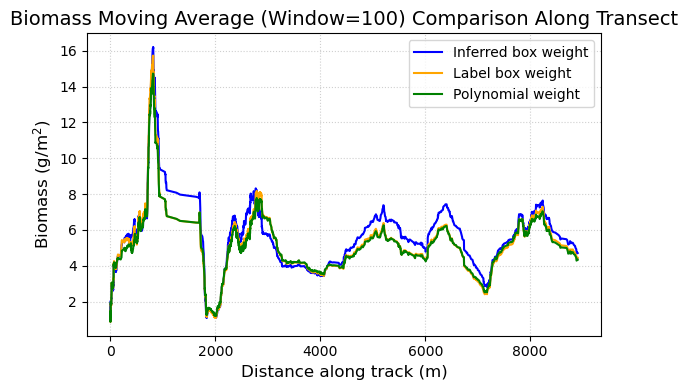

In [6]:
Transects.plot_biomass_comparison_moving_average(infer_transect=infer_biomass_df, lbl_transect=lblbox_biomass_df, poly_transect=lblpoly_biomass_df, moving_average_window=100)

analyzing 20200806_001_Iver3069_ABS1


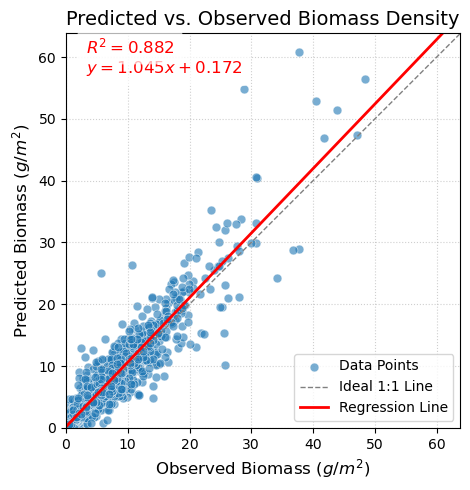

In [7]:
Transects.create_observed_vs_predicted_plot(lblpoly_biomass_df, infer_biomass_df)